In [1]:
import numpy as np
import pandas as pd
import tensorflow as tf

In [2]:
# import image processing libs
import matplotlib.pyplot as plt
from PIL import Image
import os

In [3]:
# define dataset path
dataset_path = 'dataset'

In [4]:
spiral_images = f'{dataset_path}/spiral'
wave_images = f'{dataset_path}/wave'

print(f"Spiral images path: {spiral_images}")
print(f"Wave images path: {wave_images}")

Spiral images path: dataset/spiral
Wave images path: dataset/wave


In [5]:
# Define paths for training data - COMBINED spiral and wave
spiral_training_path = f'{spiral_images}/training'
spiral_testing_path = f'{spiral_images}/testing'

wave_training_path = f'{wave_images}/training'
wave_testing_path = f'{wave_images}/testing'

print(f"Spiral training path: {spiral_training_path}")
print(f"Spiral testing path: {spiral_testing_path}")
print(f"Wave training path: {wave_training_path}")
print(f"Wave testing path: {wave_testing_path}")

Spiral training path: dataset/spiral/training
Spiral testing path: dataset/spiral/testing
Wave training path: dataset/wave/training
Wave testing path: dataset/wave/testing


### Data View

Loading an image from both healthy and parkinson's folders will help qualitatively analyse the structural differences between both of these cases

### Data Preprocessing

Setting up image preprocessing pipeline:
- Convert images to grayscale (256x256x1)
- Normalize pixel values to [0, 1]
- Apply data augmentation for training (rotation, shift, zoom, flip)
- No augmentation for testing data

In [6]:
# set seed values
SEED = 42
import random 
np.random.seed(SEED)
tf.random.set_seed(SEED)
tf.keras.utils.set_random_seed(SEED)

In [7]:
# Import TensorFlow and Keras
from tensorflow import keras
from tensorflow.keras.preprocessing.image import ImageDataGenerator

In [8]:
train_datagen = ImageDataGenerator(
    rescale=1.0 / 255,
    rotation_range=40,
    width_shift_range=0.3,
    height_shift_range=0.3,
    shear_range=0.3,
    zoom_range=0.3,
    horizontal_flip=False, # cannot flip since orientation matters
    vertical_flip=False, # same reason
    fill_mode="nearest",
    validation_split=0.2,  # Split training data: 80% train, 20% validation
)


test_datagen = ImageDataGenerator(rescale=1.0 / 255)

In [9]:
IMG_HEIGHT = 224  # Changed from 256 for MobileNetV2
IMG_WIDTH = 224
BATCH_SIZE = 16
COLOR_MODE = 'rgb'

In [10]:
# Load SPIRAL training data (80% for training)
spiral_train_generator = train_datagen.flow_from_directory(
    spiral_training_path,
    target_size=(IMG_HEIGHT, IMG_WIDTH),
    batch_size=BATCH_SIZE,
    color_mode=COLOR_MODE,
    class_mode="binary",
    shuffle=True,
    seed=42,
    subset="training",
)

# Load SPIRAL validation data (20% for validation)
spiral_val_generator = train_datagen.flow_from_directory(
    spiral_training_path,
    target_size=(IMG_HEIGHT, IMG_WIDTH),
    batch_size=BATCH_SIZE,
    color_mode=COLOR_MODE,
    class_mode="binary",
    shuffle=True,
    seed=42,
    subset="validation",
)

# Load SPIRAL testing data (for final evaluation only)
spiral_test_generator = test_datagen.flow_from_directory(
    spiral_testing_path,
    target_size=(IMG_HEIGHT, IMG_WIDTH),
    batch_size=BATCH_SIZE,
    color_mode=COLOR_MODE,
    class_mode="binary",
    shuffle=False,
    seed=42,
)

# Load WAVE training data (80% for training)
wave_train_generator = train_datagen.flow_from_directory(
    wave_training_path,
    target_size=(IMG_HEIGHT, IMG_WIDTH),
    batch_size=BATCH_SIZE,
    color_mode=COLOR_MODE,
    class_mode="binary",
    shuffle=True,
    seed=42,
    subset="training",
)

# Load WAVE validation data (20% for validation)
wave_val_generator = train_datagen.flow_from_directory(
    wave_training_path,
    target_size=(IMG_HEIGHT, IMG_WIDTH),
    batch_size=BATCH_SIZE,
    color_mode=COLOR_MODE,
    class_mode="binary",
    shuffle=True,
    seed=42,
    subset="validation",
)

# Load WAVE testing data (for final evaluation only)
wave_test_generator = test_datagen.flow_from_directory(
    wave_testing_path,
    target_size=(IMG_HEIGHT, IMG_WIDTH),
    batch_size=BATCH_SIZE,
    color_mode=COLOR_MODE,
    class_mode="binary",
    shuffle=False,
    seed=42,
)

print(f"\nSPIRAL Dataset:")
print(f"  Class indices: {spiral_train_generator.class_indices}")
print(f"  Training samples: {spiral_train_generator.samples}")
print(f"  Validation samples: {spiral_val_generator.samples}")
print(f"  Testing samples: {spiral_test_generator.samples}")

print(f"\nWAVE Dataset:")
print(f"  Class indices: {wave_train_generator.class_indices}")
print(f"  Training samples: {wave_train_generator.samples}")
print(f"  Validation samples: {wave_val_generator.samples}")
print(f"  Testing samples: {wave_test_generator.samples}")

print(f"\nTOTAL:")
print(
    f"  Training samples: {spiral_train_generator.samples + wave_train_generator.samples}"
)
print(
    f"  Validation samples: {spiral_val_generator.samples + wave_val_generator.samples}"
)
print(
    f"  Testing samples: {spiral_test_generator.samples + wave_test_generator.samples}"
)

Found 58 images belonging to 2 classes.
Found 14 images belonging to 2 classes.
Found 30 images belonging to 2 classes.
Found 58 images belonging to 2 classes.
Found 14 images belonging to 2 classes.
Found 30 images belonging to 2 classes.

SPIRAL Dataset:
  Class indices: {'healthy': 0, 'parkinson': 1}
  Training samples: 58
  Validation samples: 14
  Testing samples: 30

WAVE Dataset:
  Class indices: {'healthy': 0, 'parkinson': 1}
  Training samples: 58
  Validation samples: 14
  Testing samples: 30

TOTAL:
  Training samples: 116
  Validation samples: 28
  Testing samples: 60


In [11]:
# Create combined generators that alternate between spiral and wave
def combined_generator(gen1, gen2):
    """Combine two generators by alternating batches"""
    while True:
        # Get batch from spiral
        X1, y1 = next(gen1)
        yield X1, y1
        
        # Get batch from wave
        X2, y2 = next(gen2)
        yield X2, y2

# Create combined training and validation generators
train_generator = combined_generator(spiral_train_generator, wave_train_generator)
val_generator = combined_generator(spiral_val_generator, wave_val_generator)
test_generator = combined_generator(spiral_test_generator, wave_test_generator)

# Calculate steps per epoch
total_train_samples = spiral_train_generator.samples + wave_train_generator.samples
total_val_samples = spiral_val_generator.samples + wave_val_generator.samples
total_test_samples = spiral_test_generator.samples + wave_test_generator.samples

steps_per_epoch = total_train_samples // BATCH_SIZE
validation_steps = total_val_samples // BATCH_SIZE
test_steps = total_test_samples // BATCH_SIZE

print(f"\nCombined generators created!")
print(f"Steps per epoch (training): {steps_per_epoch}")
print(f"Validation steps: {validation_steps}")
print(f"Test steps: {test_steps}")


Combined generators created!
Steps per epoch (training): 7
Validation steps: 1
Test steps: 3


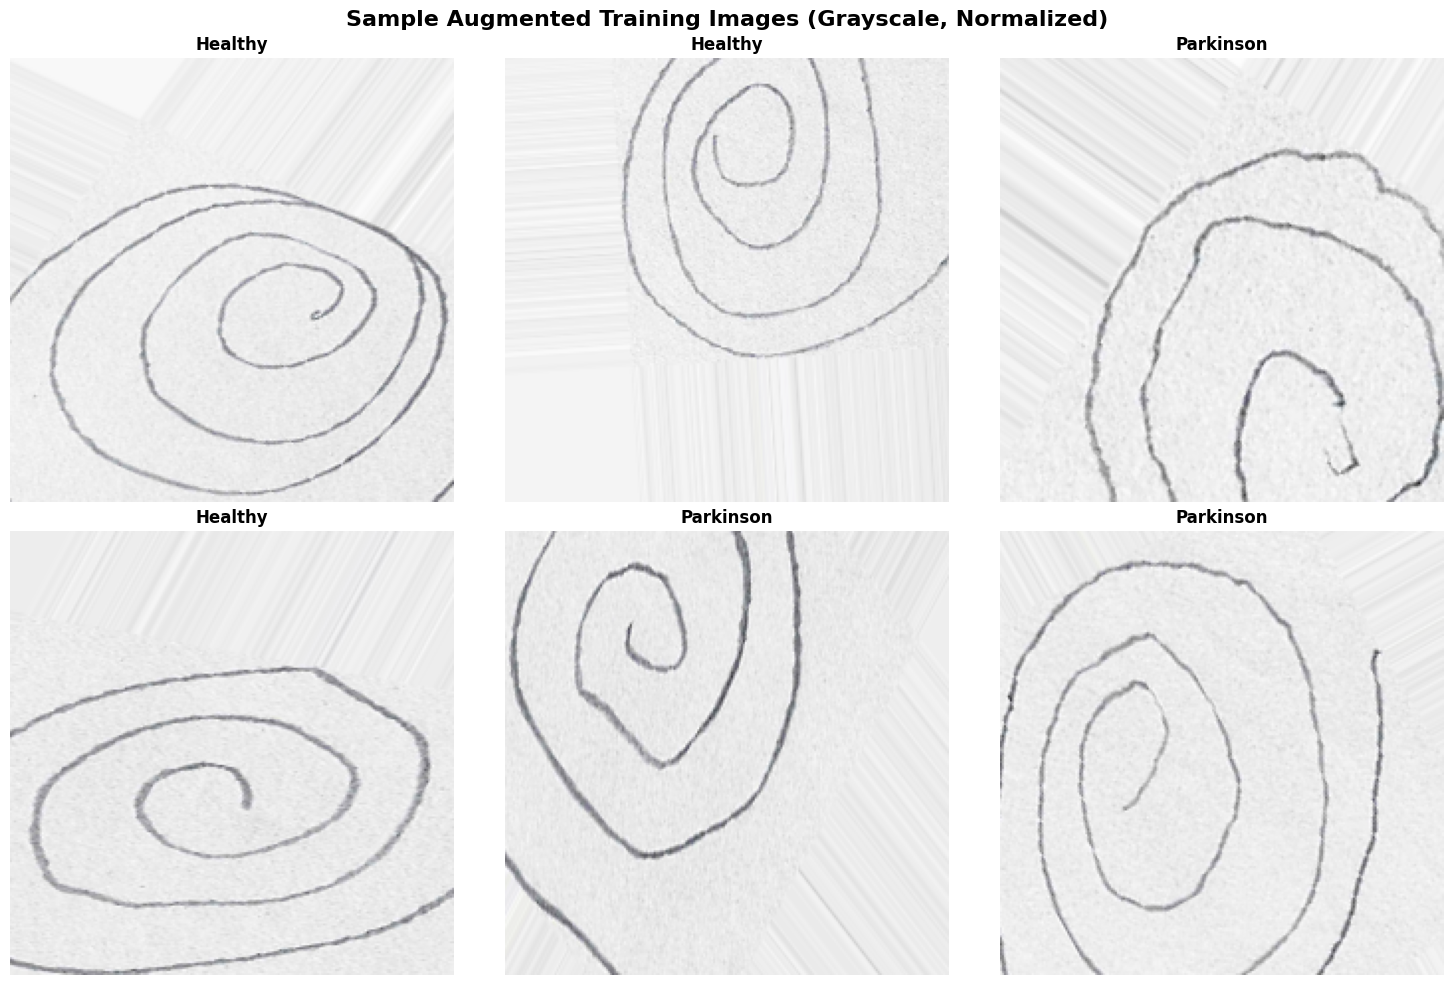


Image shape after preprocessing: (224, 224, 3)
Pixel value range: [0.274, 1.000]


In [12]:
# Visualize some augmented training images
fig, axes = plt.subplots(2, 3, figsize=(15, 10))
axes = axes.ravel()

# Get a batch of training images
sample_batch = next(train_generator)
sample_images = sample_batch[0]  # Images
sample_labels = sample_batch[1]  # Labels

class_names = {0: 'Healthy', 1: 'Parkinson'}

for i in range(6):
    axes[i].imshow(sample_images[i].squeeze(), cmap='gray')
    label = int(sample_labels[i])
    axes[i].set_title(f'{class_names[label]}', fontsize=12, fontweight='bold')
    axes[i].axis('off')

plt.suptitle('Sample Augmented Training Images (Grayscale, Normalized)', fontsize=16, fontweight='bold')
plt.tight_layout()
plt.show()

print(f"\nImage shape after preprocessing: {sample_images[0].shape}")
print(f"Pixel value range: [{sample_images[0].min():.3f}, {sample_images[0].max():.3f}]")

### Build CNN Model

Creating a Convolutional Neural Network optimized for **high recall** to minimize false negatives (missing Parkinson's cases)

In [13]:
# Import necessary layers and models
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Conv2D, MaxPool2D, Flatten, Dense, Dropout, BatchNormalization, GlobalAveragePooling2D
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau
from tensorflow.keras.applications import MobileNetV2
from tensorflow.keras.initializers import glorot_uniform
from tensorflow.keras.regularizers import l2

In [14]:
# Build model using Transfer Learning with MobileNetV2
# Pre-trained on ImageNet, fine-tuned for Parkinson's detection

# Load pre-trained MobileNetV2 (without top classification layer)
base_model = MobileNetV2(
    input_shape=(IMG_HEIGHT, IMG_WIDTH, 3),
    include_top=False,
    weights='imagenet'
)

# Freeze base model layers initially
base_model.trainable = False

# Build custom classification head
inputs = Input(shape=(IMG_HEIGHT, IMG_WIDTH, 3))
x = base_model(inputs, training=False)
x = GlobalAveragePooling2D()(x)
x = Dense(128, activation='relu')(x)
x = Dropout(0.5)(x)
x = Dense(64, activation='relu')(x)
x = Dropout(0.3)(x)
outputs = Dense(1, activation='sigmoid')(x)

model = Model(inputs=inputs, outputs=outputs, name='parkinson_mobilenet')

print(f"Base model trainable: {base_model.trainable}")
model.summary()

2025-12-07 00:49:11.955940: I metal_plugin/src/device/metal_device.cc:1154] Metal device set to: Apple M4
2025-12-07 00:49:11.955964: I metal_plugin/src/device/metal_device.cc:296] systemMemory: 16.00 GB
2025-12-07 00:49:11.955971: I metal_plugin/src/device/metal_device.cc:313] maxCacheSize: 5.33 GB
2025-12-07 00:49:11.955999: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:306] Could not identify NUMA node of platform GPU ID 0, defaulting to 0. Your kernel may not have been built with NUMA support.
2025-12-07 00:49:11.956016: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:272] Created TensorFlow device (/job:localhost/replica:0/task:0/device:GPU:0 with 0 MB memory) -> physical PluggableDevice (device: 0, name: METAL, pci bus id: <undefined>)


Base model trainable: False
Model: "parkinson_mobilenet"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 mobilenetv2_1.00_224 (Func  (None, 7, 7, 1280)        2257984   
 tional)                                                         
                                                                 
 global_average_pooling2d (  (None, 1280)              0         
 GlobalAveragePooling2D)                                         
                                                                 
 dense (Dense)               (None, 128)               163968    
                                                                 
 dropout (Dropout)           (None, 128)               0         
                                                                 
 dense_1 (Dense)   

In [15]:
# Compile with HIGHER learning rate for faster learning
from tensorflow.keras.metrics import Recall, Precision

model.compile(
    optimizer=Adam(learning_rate=0.0001),
    loss='binary_crossentropy',
    metrics=[
        'accuracy',
        Precision(name='precision'),
        Recall(name='recall')
    ]
)

print("Model compiled successfully!")
print(f"Loss: Binary Crossentropy")
print(f"Metrics: Accuracy, Precision, Recall")

Model compiled successfully!
Loss: Binary Crossentropy
Metrics: Accuracy, Precision, Recall


In [16]:
# Setup callbacks with longer patience
callbacks = [
    ModelCheckpoint(
        'best_model.keras',
        monitor='val_accuracy',
        mode='max',
        save_best_only=True,
        verbose=1
    ),
    
    EarlyStopping(
        monitor='val_accuracy',
        mode='max',
        patience=30,  # Much longer patience
        verbose=1,
        restore_best_weights=True
    ),
    
    ReduceLROnPlateau(
        monitor='val_accuracy',
        mode='max',
        factor=0.5,
        patience=10,
        min_lr=1e-6,
        verbose=1
    )
]

In [17]:
# Train the model on combined spiral + wave dataset
EPOCHS = 50

print(f"Starting training for {EPOCHS} epochs...")
print(f"Total training samples: {total_train_samples} (Spiral + Wave)")
print(f"Total validation samples: {total_val_samples} (Spiral + Wave)")
print(f"Total testing samples: {total_test_samples} (Spiral + Wave) - FOR FINAL EVALUATION ONLY")
print(f"Steps per epoch: {steps_per_epoch}")
print(f"Validation steps: {validation_steps}")

history = model.fit(
    train_generator,
    steps_per_epoch=steps_per_epoch,
    validation_data=val_generator,  # Using validation split instead of test data
    validation_steps=validation_steps,
    epochs=EPOCHS,
    callbacks=callbacks,
    verbose=1
)

print("\n" + "=" * 60)
print("Training completed!")
print("=" * 60)

Starting training for 50 epochs...
Total training samples: 116 (Spiral + Wave)
Total validation samples: 28 (Spiral + Wave)
Total testing samples: 60 (Spiral + Wave) - FOR FINAL EVALUATION ONLY
Steps per epoch: 7
Validation steps: 1
Epoch 1/50


2025-12-07 00:49:13.618434: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:117] Plugin optimizer for device_type GPU is enabled.
2025-12-07 00:49:13.684398: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:961] model_pruner failed: INVALID_ARGUMENT: Graph does not contain terminal node Adam/AssignAddVariableOp.


6/7 [========================>.....] - ETA: 0s - loss: 1.2242 - accuracy: 0.5000 - precision: 0.5143 - recall: 0.3913
Epoch 1: val_accuracy improved from -inf to 0.71429, saving model to best_model.keras
7/7 [==============================] - 2s 235ms/step - loss: 1.2127 - accuracy: 0.5000 - precision: 0.5000 - recall: 0.4200 - val_loss: 0.6615 - val_accuracy: 0.7143 - val_precision: 1.0000 - val_recall: 0.4286 - lr: 1.0000e-04
Epoch 2/50
7/7 [==============================] - ETA: 0s - loss: 1.1323 - accuracy: 0.5000 - precision: 0.5111 - recall: 0.4259
Epoch 2: val_accuracy did not improve from 0.71429
7/7 [==============================] - 0s 57ms/step - loss: 1.1323 - accuracy: 0.5000 - precision: 0.5111 - recall: 0.4259 - val_loss: 0.8729 - val_accuracy: 0.4286 - val_precision: 0.4615 - val_recall: 0.8571 - lr: 1.0000e-04
Epoch 3/50
7/7 [==============================] - ETA: 0s - loss: 0.9625 - accuracy: 0.5189 - precision: 0.4706 - recall: 0.5000
Epoch 3: val_accuracy did not im

### Model Evaluation on Test Set

Evaluating the trained model on test images to assess performance

In [18]:
# Evaluate model performance on unseen test data

# Create a fresh test generator for evaluation
combined_test_gen = combined_generator(spiral_test_generator, wave_test_generator)

test_loss, test_accuracy, test_precision, test_recall = model.evaluate(
    combined_test_gen, steps=test_steps, verbose=1
)

print(f"Loss:      {test_loss:.4f}")
print(f"Accuracy:  {test_accuracy:.4f}")
print(f"Precision: {test_precision:.4f}")
print(f"Recall:    {test_recall:.4f}")

# Calculate F1-score for balance check
f1_score = 2 * (test_precision * test_recall) / (test_precision + test_recall + 1e-7)
print(f"F1-Score:  {f1_score:.4f}")

3/3 [==============================] - 0s 35ms/step - loss: 0.6493 - accuracy: 0.6739 - precision: 0.5200 - recall: 0.8125  
Loss:      0.6493
Accuracy:  0.6739
Precision: 0.5200
Recall:    0.8125
F1-Score:  0.6341


In [19]:
# Generate confusion matrix
from sklearn.metrics import confusion_matrix

# Reset test generators
spiral_test_generator.reset()
wave_test_generator.reset()

# Collect all test predictions
y_true = []
y_pred = []

for i in range(len(spiral_test_generator)):
    X, y = next(spiral_test_generator)
    predictions = model.predict(X, verbose=0)
    y_true.extend(y)
    y_pred.extend((predictions > 0.5).astype(int).flatten())

for i in range(len(wave_test_generator)):
    X, y = next(wave_test_generator)
    predictions = model.predict(X, verbose=0)
    y_true.extend(y)
    y_pred.extend((predictions > 0.5).astype(int).flatten())

# Convert to numpy arrays
y_true = np.array(y_true)
y_pred = np.array(y_pred)

# Generate confusion matrix
cm = confusion_matrix(y_true, y_pred)

print("Confusion Matrix:")
print(cm)
print(f"True Negatives : {cm[0][0]}")
print(f"False Positives : {cm[0][1]}")
print(f"False Negatives : {cm[1][0]}")
print(f"True Positives : {cm[1][1]}")

Confusion Matrix:
[[18 12]
 [10 20]]
True Negatives : 18
False Positives : 12
False Negatives : 10
True Positives : 20
